# K-Means vs DBSCAN Clustering: A Complete Comparison
A beginner-friendly guide comparing two popular clustering algorithms with visualizations.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print('Libraries loaded successfully!')

Libraries loaded successfully!


## 1. What is Clustering?
Clustering groups similar data points together without any labels. K-Means and DBSCAN are two very different approaches to this problem.

In [3]:
# --- Algorithm Summary ---
summary = {
    'Property': ['Type', 'Clusters needed upfront?', 'Handles noise/outliers?',
                 'Works with irregular shapes?', 'Key parameters', 'Best for'],
    'K-Means': ['Centroid-based', 'Yes (choose K)', 'No', 'No (assumes spherical)',
                'n_clusters', 'Well-separated blob clusters'],
    'DBSCAN': ['Density-based', 'No', 'Yes (labels them -1)', 'Yes',
               'eps, min_samples', 'Irregular shapes, noisy data']
}
df_summary = pd.DataFrame(summary)
print(df_summary.to_string(index=False))

                    Property                      K-Means                       DBSCAN
                        Type               Centroid-based                Density-based
    Clusters needed upfront?               Yes (choose K)                           No
     Handles noise/outliers?                           No         Yes (labels them -1)
Works with irregular shapes?       No (assumes spherical)                          Yes
              Key parameters                   n_clusters             eps, min_samples
                    Best for Well-separated blob clusters Irregular shapes, noisy data


## 2. Generate Datasets
We'll test both algorithms on 4 types of data to see where each shines or struggles.

In [4]:
# Create 4 different datasets
n = 300

# Dataset 1: Blob clusters (K-Means friendly)
X_blobs, y_blobs = make_blobs(n_samples=n, centers=3, cluster_std=0.8, random_state=42)

# Dataset 2: Moon shapes (DBSCAN friendly)
X_moons, y_moons = make_moons(n_samples=n, noise=0.08, random_state=42)

# Dataset 3: Concentric circles (DBSCAN friendly)
X_circles, y_circles = make_circles(n_samples=n, noise=0.05, factor=0.5, random_state=42)

# Dataset 4: Blobs with outliers (tests noise handling)
X_noisy, y_noisy = make_blobs(n_samples=n, centers=3, cluster_std=0.6, random_state=42)
# Add random outliers
outliers = np.random.uniform(low=-8, high=8, size=(30, 2))
X_noisy = np.vstack([X_noisy, outliers])
y_noisy = np.hstack([y_noisy, [-1]*30])

# Scale all datasets
scaler = StandardScaler()
datasets = {
    'Blob Clusters': scaler.fit_transform(X_blobs),
    'Moon Shapes': scaler.fit_transform(X_moons),
    'Concentric Circles': scaler.fit_transform(X_circles),
    'Blobs + Outliers': scaler.fit_transform(X_noisy)
}

print('Datasets ready:')
for name, data in datasets.items():
    print(f'  {name}: {data.shape[0]} points')

Datasets ready:
  Blob Clusters: 300 points
  Moon Shapes: 300 points
  Concentric Circles: 300 points
  Blobs + Outliers: 330 points


## 3. Visualize the Raw Data

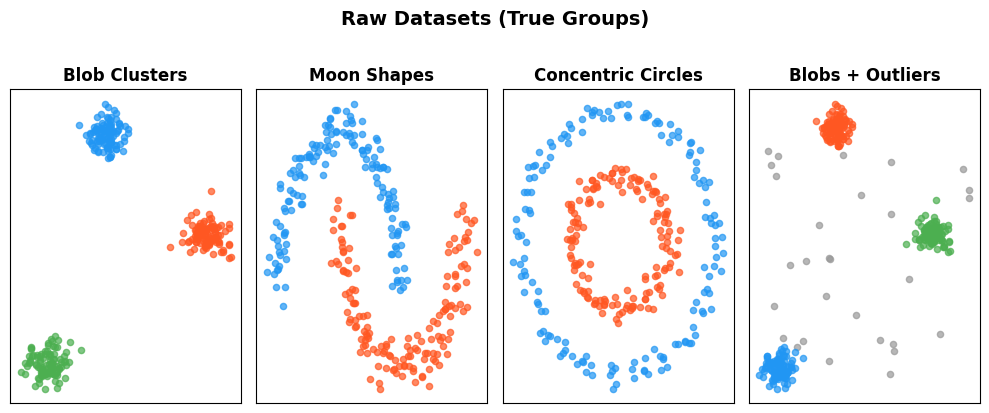

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
colors_raw = ['#2196F3', '#FF5722', '#4CAF50']

raw_labels = [y_blobs, y_moons, y_circles, y_noisy]

for ax, (name, X), labels in zip(axes, datasets.items(), raw_labels):
    unique = np.unique(labels)
    for i, label in enumerate(unique):
        mask = labels == label
        color = '#999999' if label == -1 else colors_raw[i % len(colors_raw)]
        ax.scatter(X[mask, 0], X[mask, 1], c=color, s=20, alpha=0.7)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('Raw Datasets (True Groups)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('raw_datasets.png', dpi=10, bbox_inches='tight')
plt.show()

## 4. Apply K-Means Clustering

In [6]:
# K-Means requires us to specify number of clusters
kmeans_params = {
    'Blob Clusters': 3,
    'Moon Shapes': 2,
    'Concentric Circles': 2,
    'Blobs + Outliers': 3
}

kmeans_results = {}
for name, X in datasets.items():
    k = kmeans_params[name]
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    kmeans_results[name] = {
        'labels': labels,
        'centroids': km.cluster_centers_,
        'inertia': km.inertia_,
        'k': k
    }
    print(f'{name}: K={k}, Inertia={km.inertia_:.2f}')

Blob Clusters: K=3, Inertia=11.88
Moon Shapes: K=2, Inertia=250.93
Concentric Circles: K=2, Inertia=378.06
Blobs + Outliers: K=3, Inertia=35.00


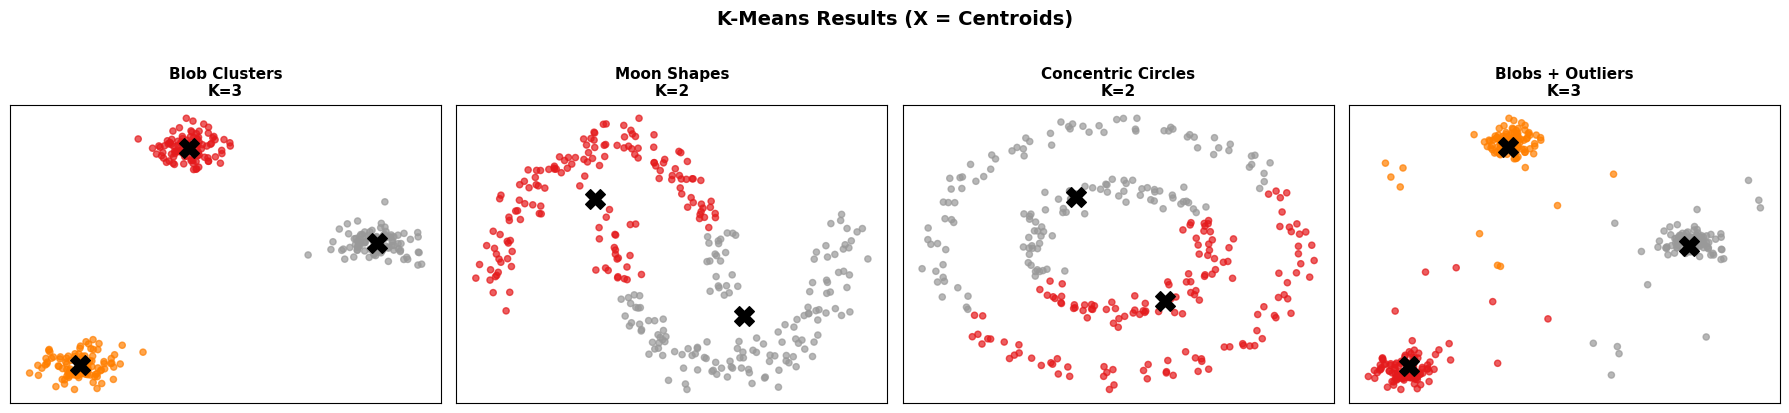

In [7]:
# Plot K-Means results
cmap = plt.cm.Set1
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, (name, X) in zip(axes, datasets.items()):
    res = kmeans_results[name]
    labels = res['labels']
    centroids = res['centroids']
    
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='Set1', s=20, alpha=0.7)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, zorder=5, label='Centroids')
    ax.set_title(f'{name}\nK={res["k"]}', fontsize=11, fontweight='bold')
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('K-Means Results (X = Centroids)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('kmeans_results.png', dpi=10, bbox_inches='tight')
plt.show()

## 5. Apply DBSCAN Clustering

In [8]:
# DBSCAN parameters:
#   eps = neighborhood radius (how close points must be to be neighbors)
#   min_samples = minimum points to form a dense region (core point)

dbscan_params = {
    'Blob Clusters':       {'eps': 0.4, 'min_samples': 5},
    'Moon Shapes':         {'eps': 0.2, 'min_samples': 5},
    'Concentric Circles':  {'eps': 0.2, 'min_samples': 5},
    'Blobs + Outliers':    {'eps': 0.35, 'min_samples': 5}
}

dbscan_results = {}
for name, X in datasets.items():
    params = dbscan_params[name]
    db = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = db.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    dbscan_results[name] = {'labels': labels, 'n_clusters': n_clusters, 'n_noise': n_noise, **params}
    
    print(f'{name}: Clusters found={n_clusters}, Noise points={n_noise}, eps={params["eps"]}')

Blob Clusters: Clusters found=3, Noise points=0, eps=0.4
Moon Shapes: Clusters found=7, Noise points=10, eps=0.2
Concentric Circles: Clusters found=18, Noise points=29, eps=0.2
Blobs + Outliers: Clusters found=3, Noise points=25, eps=0.35


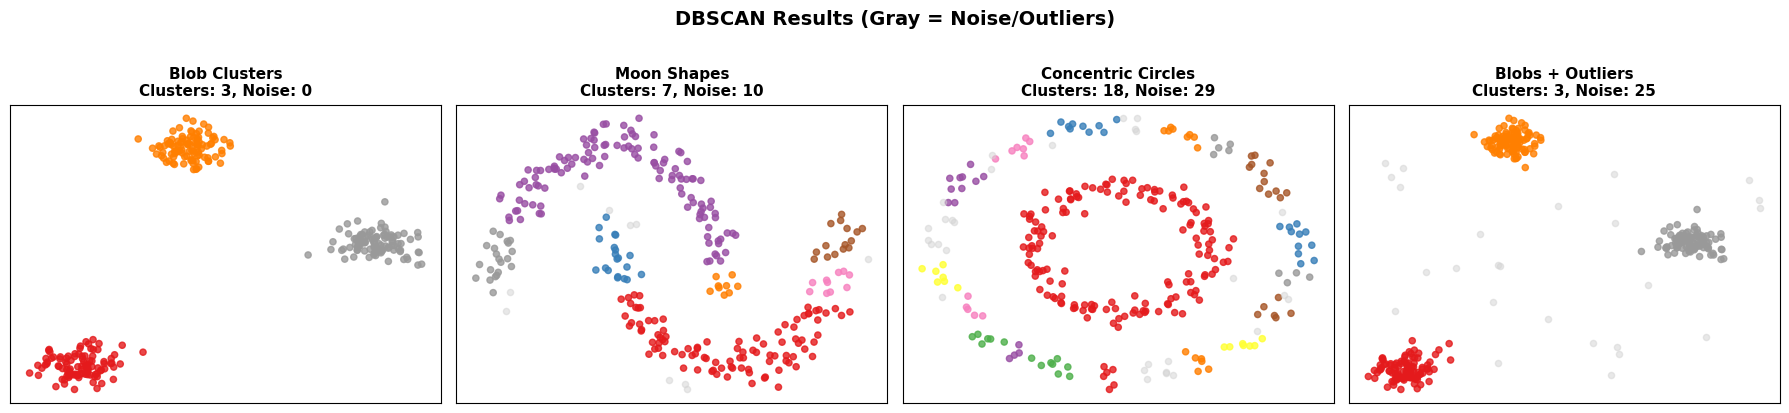

In [9]:
# Plot DBSCAN results
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, (name, X) in zip(axes, datasets.items()):
    res = dbscan_results[name]
    labels = res['labels']
    
    # Noise points (label == -1) shown in gray
    noise_mask = labels == -1
    cluster_mask = ~noise_mask
    
    if cluster_mask.any():
        ax.scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                   c=labels[cluster_mask], cmap='Set1', s=20, alpha=0.8)
    if noise_mask.any():
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1],
                   c='lightgray', s=20, alpha=0.5, label='Noise')
    
    ax.set_title(f'{name}\nClusters: {res["n_clusters"]}, Noise: {res["n_noise"]}',
                 fontsize=11, fontweight='bold')
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('DBSCAN Results (Gray = Noise/Outliers)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('dbscan_results.png', dpi=10, bbox_inches='tight')
plt.show()

## 6. Side-by-Side Comparison

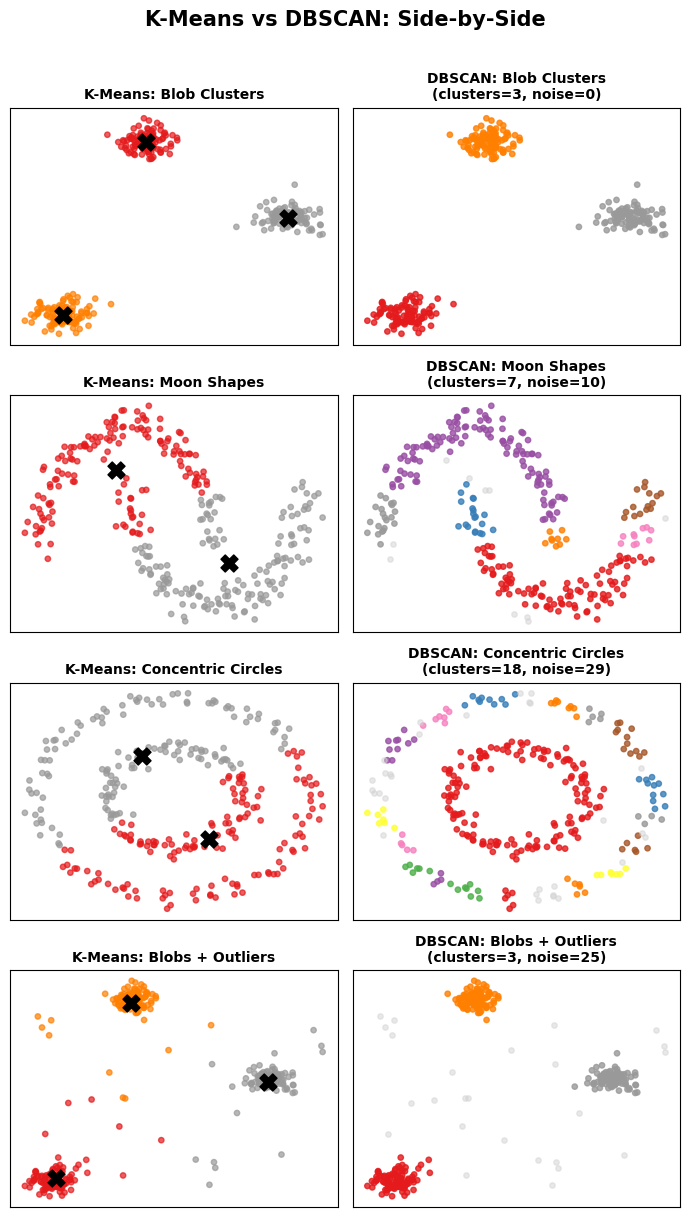

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(7, 12))

for row, (name, X) in enumerate(datasets.items()):
    km_labels = kmeans_results[name]['labels']
    db_labels = dbscan_results[name]['labels']
    km_centroids = kmeans_results[name]['centroids']
    
    # K-Means
    ax_km = axes[row, 0]
    ax_km.scatter(X[:, 0], X[:, 1], c=km_labels, cmap='Set1', s=15, alpha=0.7)
    ax_km.scatter(km_centroids[:, 0], km_centroids[:, 1], c='black', marker='X', s=150, zorder=5)
    ax_km.set_title(f'K-Means: {name}', fontsize=10, fontweight='bold')
    ax_km.set_xticks([]); ax_km.set_yticks([])
    
    # DBSCAN
    ax_db = axes[row, 1]
    noise_mask = db_labels == -1
    if (~noise_mask).any():
        ax_db.scatter(X[~noise_mask, 0], X[~noise_mask, 1],
                      c=db_labels[~noise_mask], cmap='Set1', s=15, alpha=0.8)
    if noise_mask.any():
        ax_db.scatter(X[noise_mask, 0], X[noise_mask, 1],
                      c='lightgray', s=15, alpha=0.5)
    
    db_k = dbscan_results[name]['n_clusters']
    db_n = dbscan_results[name]['n_noise']
    ax_db.set_title(f'DBSCAN: {name}\n(clusters={db_k}, noise={db_n})', fontsize=10, fontweight='bold')
    ax_db.set_xticks([]); ax_db.set_yticks([])

plt.suptitle('K-Means vs DBSCAN: Side-by-Side', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('comparison_sidebyside.png', dpi=10, bbox_inches='tight')
plt.show()

## 7. Finding the Right K for K-Means: Elbow Method

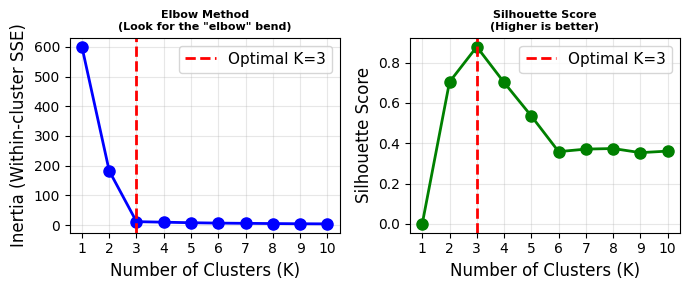

Best K by silhouette: 3
Best K by elbow: visually around K=3


In [11]:
# The Elbow Method helps choose K by plotting inertia (within-cluster sum of squares)
# We pick K where the curve bends like an elbow

X_blob = datasets['Blob Clusters']
K_range = range(1, 11)
inertias = []
silhouettes = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_blob)
    inertias.append(km.inertia_)
    if k > 1:
        silhouettes.append(silhouette_score(X_blob, labels))
    else:
        silhouettes.append(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

# Elbow curve
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Optimal K=3')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster SSE)', fontsize=12)
ax1.set_title('Elbow Method\n(Look for the "elbow" bend)', fontsize=8, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_range)

# Silhouette scores
ax2.plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Optimal K=3')
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score\n(Higher is better)', fontsize=8, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(K_range)

plt.tight_layout()
plt.savefig('elbow_silhouette.png', dpi=10, bbox_inches='tight')
plt.show()

print(f'Best K by silhouette: {np.argmax(silhouettes)+1}')
print(f'Best K by elbow: visually around K=3')

## 8. Finding the Right eps for DBSCAN: k-NN Distance Plot

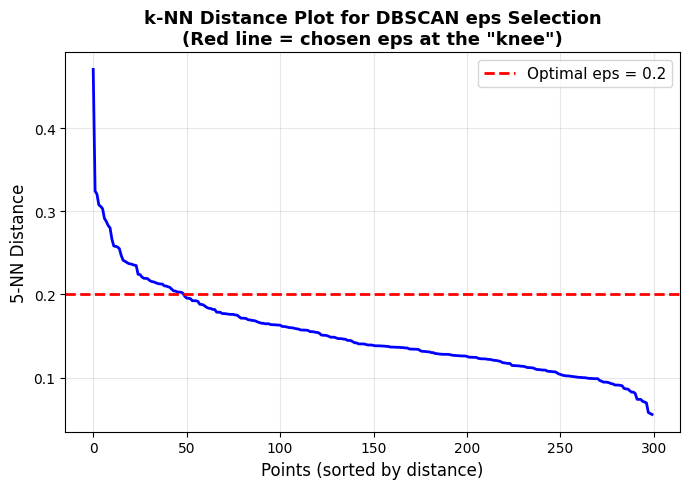

In [12]:
from sklearn.neighbors import NearestNeighbors

# The k-distance graph helps find the right eps
# Look for the "knee" point in the graph - that's your eps

X_moon = datasets['Moon Shapes']
min_samples = 5

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_moon)
distances, _ = nbrs.kneighbors(X_moon)
k_distances = np.sort(distances[:, -1])[::-1]

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(k_distances, 'b-', linewidth=2)
ax.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Optimal eps = 0.2')
ax.set_xlabel('Points (sorted by distance)', fontsize=12)
ax.set_ylabel(f'{min_samples}-NN Distance', fontsize=12)
ax.set_title('k-NN Distance Plot for DBSCAN eps Selection\n(Red line = chosen eps at the "knee")',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('eps_selection.png', dpi=10, bbox_inches='tight')
plt.show()

## 9. DBSCAN eps Sensitivity Analysis

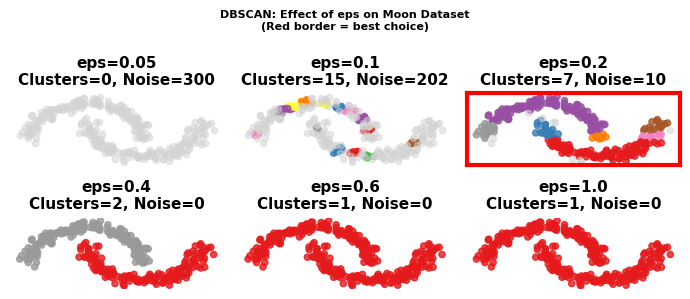

In [18]:
# See how different eps values change DBSCAN's behavior
X_moon = datasets['Moon Shapes']
eps_values = [0.05, 0.1, 0.2, 0.4, 0.6, 1.0]

fig, axes = plt.subplots(2, 3, figsize=(7, 3))
axes = axes.flatten()

for ax, eps in zip(axes, eps_values):
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_moon)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    
    noise_mask = labels == -1
    if (~noise_mask).any():
        ax.scatter(X_moon[~noise_mask, 0], X_moon[~noise_mask, 1],
                   c=labels[~noise_mask], cmap='Set1', s=20, alpha=0.8)
    if noise_mask.any():
        ax.scatter(X_moon[noise_mask, 0], X_moon[noise_mask, 1],
                   c='lightgray', s=20, alpha=0.5)
    
    border = 'red' if eps == 0.2 else 'none'
    for spine in ax.spines.values():
        spine.set_edgecolor(border)
        spine.set_linewidth(3 if eps == 0.2 else 1)
    
    ax.set_title(f'eps={eps}\nClusters={n_clusters}, Noise={n_noise}',
                 fontsize=11, fontweight='bold')
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('DBSCAN: Effect of eps on Moon Dataset\n(Red border = best choice)',
             fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('eps_sensitivity.png', dpi=10, bbox_inches='tight')
plt.show()

## 10. Evaluation Metrics

In [14]:
# Three common metrics for evaluating clustering (no labels needed!)
# Silhouette Score: -1 to 1, higher = better separation
# Davies-Bouldin: lower = better (compact, well-separated clusters)
# Calinski-Harabasz: higher = better (dense, well-separated)

metrics = []

for name, X in datasets.items():
    for algo in ['KMeans', 'DBSCAN']:
        if algo == 'KMeans':
            labels = kmeans_results[name]['labels']
        else:
            labels = dbscan_results[name]['labels']
        
        # DBSCAN might mark everything as noise
        valid_mask = labels != -1
        n_unique = len(set(labels[valid_mask])) if valid_mask.sum() > 0 else 0
        
        if n_unique >= 2 and valid_mask.sum() > 1:
            X_valid = X[valid_mask]
            l_valid = labels[valid_mask]
            sil = silhouette_score(X_valid, l_valid)
            db_score = davies_bouldin_score(X_valid, l_valid)
            ch_score = calinski_harabasz_score(X_valid, l_valid)
        else:
            sil, db_score, ch_score = np.nan, np.nan, np.nan
        
        metrics.append({
            'Dataset': name, 'Algorithm': algo,
            'Silhouette': round(sil, 3) if not np.isnan(sil) else 'N/A',
            'Davies-Bouldin': round(db_score, 3) if not np.isnan(db_score) else 'N/A',
            'Calinski-Harabasz': round(ch_score, 1) if not np.isnan(ch_score) else 'N/A'
        })

df_metrics = pd.DataFrame(metrics)
print(df_metrics.to_string(index=False))

           Dataset Algorithm  Silhouette  Davies-Bouldin  Calinski-Harabasz
     Blob Clusters    KMeans       0.878           0.169             7351.6
     Blob Clusters    DBSCAN       0.878           0.169             7351.6
       Moon Shapes    KMeans       0.494           0.806              414.6
       Moon Shapes    DBSCAN       0.219           0.844              155.1
Concentric Circles    KMeans       0.353           1.175              174.9
Concentric Circles    DBSCAN       0.131           0.583               46.3
  Blobs + Outliers    KMeans       0.836           0.209             2920.0
  Blobs + Outliers    DBSCAN       0.906           0.130            12376.5


## 11. Real-World Example: Customer Segmentation

In [15]:
# Simulate customer data: Annual Income vs Spending Score
np.random.seed(42)

# Create realistic customer segments
low_income_low_spend = np.random.multivariate_normal([20, 20], [[15, 5], [5, 15]], 80)
low_income_high_spend = np.random.multivariate_normal([25, 80], [[15, -5], [-5, 15]], 60)
mid_income_mid_spend = np.random.multivariate_normal([55, 50], [[20, 0], [0, 20]], 100)
high_income_low_spend = np.random.multivariate_normal([80, 20], [[15, 5], [5, 15]], 70)
high_income_high_spend = np.random.multivariate_normal([85, 85], [[15, 5], [5, 15]], 90)

customers = np.vstack([low_income_low_spend, low_income_high_spend,
                       mid_income_mid_spend, high_income_low_spend, high_income_high_spend])

# Clip to realistic range
customers = np.clip(customers, 0, 100)
df_customers = pd.DataFrame(customers, columns=['Annual Income (k$)', 'Spending Score (1-100)'])

print(f'Customer dataset: {len(df_customers)} records')
print(df_customers.describe().round(2))

Customer dataset: 400 records
       Annual Income (k$)  Spending Score (1-100)
count              400.00                  400.00
mean                54.99                   51.34
std                 26.60                   27.77
min                 13.04                   12.43
25%                 25.32                   21.70
50%                 56.51                   49.96
75%                 82.12                   81.42
max                 93.68                   95.82


## 12. Final Summary

In [16]:
summary_data = {
    'Criteria': [
        'Needs number of clusters upfront',
        'Handles noise and outliers',
        'Finds arbitrary shaped clusters',
        'Works well on blob data',
        'Scales to large datasets',
        'Easy to tune',
        'Consistent results (deterministic)',
    ],
    'K-Means': ['Yes (limitation)', 'No (sensitive)', 'No (spherical only)', 'Yes (strength)', 'Yes', 'Yes (just K)', 'No (random init)'],
    'DBSCAN':  ['No (auto-finds)', 'Yes (labels as -1)', 'Yes (any shape)', 'Yes', 'Moderate', 'Moderate (eps + min_samples)', 'Yes']
}

df_final = pd.DataFrame(summary_data)
print('FINAL COMPARISON SUMMARY')
print('='*65)
print(df_final.to_string(index=False))
print('='*65)
print()
print('USE K-MEANS WHEN:')
print('  - You know (or can estimate) the number of clusters')
print('  - Data forms roughly round/spherical clusters')
print('  - Dataset is large and speed matters')
print()
print('USE DBSCAN WHEN:')
print('  - You do not know how many clusters exist')
print('  - Clusters have irregular shapes')
print('  - There are outliers or noise in the data')

FINAL COMPARISON SUMMARY
                          Criteria             K-Means                       DBSCAN
  Needs number of clusters upfront    Yes (limitation)              No (auto-finds)
        Handles noise and outliers      No (sensitive)           Yes (labels as -1)
   Finds arbitrary shaped clusters No (spherical only)              Yes (any shape)
           Works well on blob data      Yes (strength)                          Yes
          Scales to large datasets                 Yes                     Moderate
                      Easy to tune        Yes (just K) Moderate (eps + min_samples)
Consistent results (deterministic)    No (random init)                          Yes

USE K-MEANS WHEN:
  - You know (or can estimate) the number of clusters
  - Data forms roughly round/spherical clusters
  - Dataset is large and speed matters

USE DBSCAN WHEN:
  - You do not know how many clusters exist
  - Clusters have irregular shapes
  - There are outliers or noise in the data
